# Neural Algorithm of Artistic Style

**_Style transfer_** je tehnika koja podrazumeva koriscenje 3 slike: *content* sliku, *style* sliku i ulaznu sliku koju zelimo stilizovati. Za razliku od rada "Neural Algorithm of Artistic Style" u ovoj implementaciji umesto white noise slike koristi se content slika.

Princip rada *Neural style tranfer*-a je da se definisu dve *loss* funkcije, jedna koja se odnosi na sadrzaj slike, a druga na stil. Dalje, ulazna slika se menja tako da se minimizuju ove funkcije, odnosno da se zadrzi sadrzaj originalne fotografije uz dodavanje stila *style* slike. 

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)
matplotlib.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

C:\Users\ASUS\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


*Eager execution* omogucava izracunavanje operanada istog trenutka, bez stvaranja grafova koji kasnije izracunavaju trazene vrednosti. Takodje, kod se na ovaj nacin lase struktuira i debaguje. 
Kasnije cemo videti da je na ovaj nacin znatno olaksana propagacija unazad, koriscenjem tf.GradientTape-a koji sluzi da na lak nacin proracunaju gradijenti. 

In [2]:
tf.enable_eager_execution()

In [3]:
content_path = 'C:/Users/ASUS/Desktop/ML/Style Transfer/biljka.jpeg'
style_path = 'C:/Users/ASUS/Desktop/ML/Style Transfer/sunflowers.jpg'

## Vizuelizacija slika i fotografija

In [4]:
def load_img(path_to_img):
    max_dim = 512
    #max_dim = 256
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    # pil slika se prebacuje u niz
    img = kp_image.img_to_array(img) 
    # dodaje se batch dimenzija
    img = np.expand_dims(img, axis=0)
    return img

In [5]:
def imshow(img, title=None):
    # sklanja se batch dimenzija
    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
        plt.imshow(out)

Sledi prikaz *content* i *style* slike. Cilj ce biti da se ove dve slike "spoje" u jednu. 

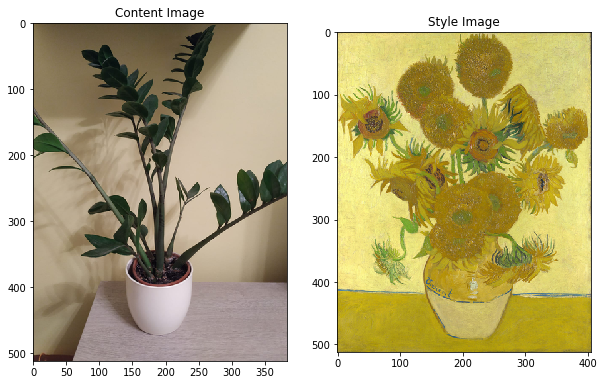

In [6]:
plt.figure(figsize=(10,10))

style = load_img(style_path).astype('uint8')
content = load_img(content_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

## Priprema podataka

Slede funkcije koje procesuju slike da bi bile pogodne kao ulaz u VGG neuralnu mrezu. One se treniraju na slikama ciji je svaki kanal normalizovan sa srednjom vrednoscu od [103.939, 116.779, 123.68] i BGR kanalima.

In [7]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

Da bi se slika nakon optimizacije prikazala, potrebno je da se uradi inverzno procesiranje. 

In [8]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Optimizovana slika mora biti oblika: [1, height, width, channel] ili [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Slika za deprocesiranje nije u odgovarajucem formatu!")

    # inverzna transformacija malopredjasnjem pretprocesiranju slike
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    
    # Optimizovana slika moze uzimati vrednosti od -inf do inf, zato se klipuje na raspon 0-255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### **_Content & Style_**

Da bi se dobila reprezentacija i stila i sadrzaja slike, potrebno je razmatrazi srednje slojeve modela neuralne mreze i to kako oni "vide" sliku. Kako se ide dublje kroz slojeve, srednji slojevi sadrze obelezja viseg reda. U ovom kodu kosricena je VGG19 arhitektura koja predstavlja *pretrained* mrezu za klasifikaciju slika.

Da bi VGG mreza naucila sta se na slici nalazi, ona mora da razume sliku i da napravi internu reprezentaciju kroz razlicite transformacije ulazne slike. Ona sirove piksele pretvara u kompleksno razumevanje obelezja prikazanih na slici. Da bi se proracunao gubitak informacija stila i sadrzaja, posmatrace se izlazi iz sledecih slojeva:

In [9]:
# Content sloj
content_layers = ['block5_conv2'] 

# Style slojevi
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## VGG19 model

Koristimo *pretrained* VGG19 model kome dajemo ulazni tensor (sliku) i zadajemo mu koje izlazne slojeve zelimo. Na ovaj nacin moguce je 'izvuci' mape obelezja iz srednjih slojeva pomocu Keras-ovog Functional API-a. Potrebno je samo definisati ulaz i izlaz modela, sto je i uradjeno u narednoj funkciji.

In [10]:
def get_model():
    # Ucitavanje pretrained modela treniranog na ImageNet podacima
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False # slojevi ne smeju da se treniraju
    # Izlazni srednji slojevi koji se odnose na stil i sadrzaj slike
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    # funkcija vraca zeljeni model
    return models.Model(vgg.input, model_outputs)

## Loss funkcije za content i style

### Content Loss

Funkcija za content loss je dosta jednostavnija nego funkcija za style loss. Funkciji se prosledjuje izlaz iz srednjih slojeva neuralne mreze koji smo sami definisali i target slika ciji sadrzaj zelimo da oponasamo (content slika). Zatim se proracunava euklidsko rastojanje izmedju ove dve slike koje predstavlja *loss* koji zelimo da izracunamo. Ovaj *loss* se minimizuje tako sto se vrsi propagacija unazad. Na taj nacin se inicijalna ulazna slika menja u svakoj iteraciji. 

Neka izlazna slika srednjeg sloja bude $x$, a content slika $p$. Neka je $C_{nn}$ pre-trained konvoluciona neuralna mreza. Tada je $C_{nn}(X)$ mreza kojoj je kao ulaz data slika $X$. Neka $F^l_{ij}(x) \in C_{nn}(x)$ i $P^l_{ij}(p) \in C_{nn}(p)$ opisuju mape obelezja nase mreze sa ulazima $x$ i $p$ u sloju $l$. Tada je opisano rastojanje sadrzaja (*loss*) formalno: 
$$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$

Primenom propagacije unazad, ovo rastojanje se minimizira i ulazna slika generise slican sadrzaj u razmatranom srednjem sloju kao sto poseduje content slika.

In [11]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

## Style Loss

Style loss je malo komplikovanije izracunati. Ovoj funkciji se ne prosledjuje sirov izlaz nekog od srednjih slojeva kao kod *content loss*-a, vec se za ove izlaze proracunava *Gram* matrica. Ona se proracunava i za target *style* sliku ciji stil zelimo da oponasamo, pa se izmedju njih racuna "rastojanje". Gram matrica $G^l_{ij}$ prestavlja proizvod vektorizovanih feature mapa $i$ i $j$ u sloju $l$. Ona u sustini predstavlja korelaciju izmedju feature mapa $i$ i $j$.

Da bi se stil preneo na ulaznu sliku, koristi se propagacija unazad tako sto se minimizuje srednja kvadratna razdaljina izmedju gram matrica *style* slike i ulazne slike (izvucene iz srednjeg sloja). Za svaki sloj to izgleda ovako:
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

gde su $G^l_{ij}$ and $A^l_{ij}$ reprezenti stila u slojevu $l$. $N_l$ predstavlja broj feature mapa gde je svaka velicine: $M_l = height * width$. Ukupan *style loss* za sve slojeve iznosi:

$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$

gde je doprinos svakog sloja ponderisan faktorom $w_1$. U ovom slucaju taj faktor je konstantan i iznosi: ($w_l =\frac{1}{|L|}$)

In [12]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1]) # kanali slike
    a = tf.reshape(input_tensor, [-1, channels]) # podela na kanale
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True) # proracun Gram matrice
    return gram / tf.cast(n, tf.float32) # vracanje normalizovane vrednosti

def get_style_loss(base_style, gram_target):
    # ulazni parametri su dve slike dimenzija: height, width, num channels
    # Loss svakog sloja se sklaira velicinom feature mapa i brojem kanala
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

## Gradient descent


Koristimo Adam optimizator da bi optimizovali *loss* funkciju. Uobicajeno, propagacija unazad menja tezine same neuralne mreze, ali posto koristimo pretrained mrezu cije tezine ne zelimo da menjamo, umesto tezina mreze menjamo ulaznu sliku tako da minimizujemo *loss* funkciju u narednim iteracijama. 

Prvo definisemo helper funkciju koja ucitava *content* i *style* sliku, daje ih nasoj mrezi kao ulaz, i zatim dobijamo izlaze iz prethodno definisanih srednjih slojeva mreze koji predstavljaju povratnu vrenost funkcije.

In [13]:
def get_feature_representations(model, content_path, style_path):
    # Ucitavanje slika
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # Slike postaju ulaz u mrezu, dobijamo vec definisan izlaz
    style_outputs = model(style_image)
    content_outputs = model(content_image)

    # Razdvajamo izlaz na content i style obelezja 
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [14]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """Ova funkcija proracunava ukupan loss

    Argumenti:
    model: Model koji daje pristup srednjim slojevima
    loss_weights: Tezine dorinosa svake loss funkcije(style weight, content weight)
    init_image: Ilicijalna ulazna slika. Ovo je slika koju menjamo optimizacioniom procesom. Primenjujemo gradijente 
    na ovoj slici u skladu sa loss funkcijom proracunatom nad njoj.
    gram_style_features: Precomputed Gram matrice koje odgovaraju izlazu srednjih slojeva
    nakon feedovanja style slike
    content_features: Precomputed izlazi iz definisanih content slojeva nakon feedovanja
    content slike.

    Povratne vrednosti:
    returns the total loss, style loss, content loss
    """
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0
    
    # Akumulirani style losses iz svih slojeva
    # Jednako se ponderisu svi "gubici" svakog sloja
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    # Akumulirani content losses iz svih slojeva
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
    style_score *= style_weight
    content_score *= content_weight

    # Ukupan loss
    loss = style_score + content_score 
    return loss, style_score, content_score

In [15]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # izracunavaju se gradijetni u skladu sa ulaznom slikom
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss #proracunava se gradijent, odnosno kako se menja
#inicijalna ulazna slika u skladu sa loss funkcijom

### Optimization loop

In [16]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 

    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
  
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Inicijalna ulazna slika
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    # Optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    # Pomocna promenljiva za prikaz srednjih slojeva
    iter_count = 1

    # Cuvanje najboljeg rezultata
    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }

    # Pomocne promenljive za prikaz
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
    
        if loss < best_loss: 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval == 0:
            start_time = time.time()

            # Pretvaranje tensora u numpy niz
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, '
                'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    #IPython.display.clear_output(wait=True)
#     plt.figure(figsize=(14,4))
#     for i,img in enumerate(imgs):
#         plt.subplot(num_rows,num_cols,i+1)
#         plt.imshow(img)
#         plt.xticks([])
#         plt.yticks([])

    return best_img, best_loss 

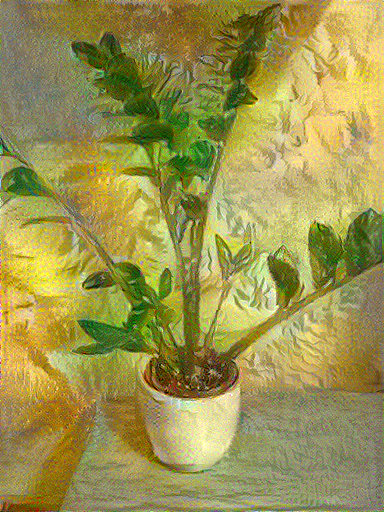

Iteration: 450
Total loss: 4.7528e+05, style loss: 1.9509e+05, content loss: 2.8019e+05, time: 0.1142s
Total time: 4816.3128s


In [17]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=500)

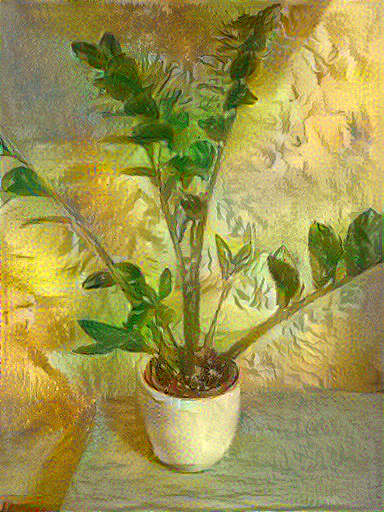

In [18]:
Image.fromarray(best)

## Visualize outputs
We "deprocess" the output image in order to remove the processing that was applied to it. 

In [19]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path) 
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

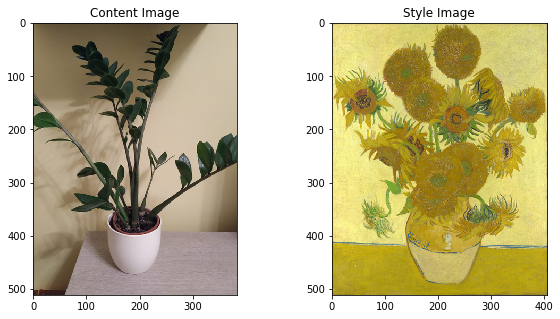

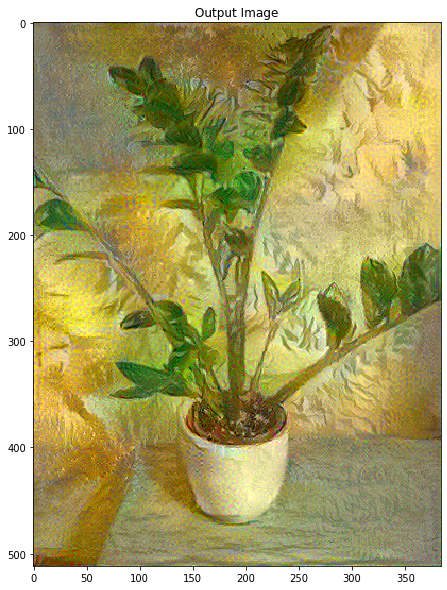

In [20]:
show_results(best, content_path, style_path)